# DAF - Torino: data processing 

In questo notebook vengono elencate le operazioni di preprocessing da effettuare sui dataset del comune di Torino (AperTO) prima di procedere all'inserimento nella piattaforma DAF.

I dataset presenti ad oggi mappano i servizi nelle circoscrizioni e non nei quartieri.

Avendo a disposizione i poligoni dei quartieri e la geometry del servizio è possibile tramite sei servizi offerti ad esempio con geopandas collocare ogni servizio nel quartiere di appartenenza geografica.

In fase iniziale si scaricheranno in locale i dataset in formato csv e da questi si procedera con le elaborazioni necessarie e il caricamento in DAF. 

E' importante tenere in considerazione che sarà necessario stabilire dei flussi di aggiornamento in base alle note sotto riportate.


[Geoportale:](http://www.comune.torino.it/geoportale/ser_professionali_2.htm#tabs-4)



**NOTA:** 

La periodicità di aggiornamento è riferita ai dati pubblicati e consultabili sul Visualizzatore del Geoportale.

- Aggiornamento settimanale: lunedì.
- Aggiornamento trimestrale: gennaio, aprile, luglio, ottobre.
- Aggiornamento semestrale: gennaio, luglio.
- Aggiornamento annuale: 31/12 dell’anno di riferimento.
- L’aggiornamento non è previsto per i dati storici, riferiti a dati consolidati ad una certa data (es. ex quartieri).
- L'aggiornamento su segnalazione avviene su richiesta del titolare del dato.


### Conversione formato geografico per dataset di AperTO

Per ogni dataset è necessario:

- inserire il campo **"CATEGORIA"** che non è indicato nel dataset stesso ma si recupera nell'alberatura della struttura proposta dal Geoportale (volendo può essere in parte rimpiazzato dalla categorie di DAF ma ritengo possa essere utile inserirlo nel dataset anche se l'info viene poi ridondata su tutti i record)

- convertire le info geografiche nel formato **WSG84**: i dati della Città di Torino sono acquisiti nel sistema di riferimento Gauss Boaga sui grigliati catastali. Il codice internazionale di riferimento è: 

EPSG 3003 – Monte Mario Italy Zone 1. 

In particolare per ogni dataset in cui i record rappresentano dei punti geografici, è necessario convertire anche le colonne riferite a latitudine e longitudine.
Queste informazioni saranno poi utili per la visualizzazione su Superset.

- prevedere il campo **"QUARTIERE"** che sarà inizialmente vuoto e che verrà poi valorizzato con il quartiere di riferimento che al momento oggi non è presente


In [1]:
import pandas as pd
import json 
import os
import glob
import geopandas as gpd
import shapely.wkt
from geopandas import GeoDataFrame
from shapely.geometry import Point
from fiona.crs import from_epsg

In [2]:
#http://www.spatialreference.org/ref/epsg/2263/
def df_to_gdf_convert(input_df, input_crs, output_crs, input_geo): #read 3003, convert to WSG84
    """
    Convert a DataFrame with longitude and latitude columns
    to a GeoDataFrame. 3003
    """
    crs = {'init': 'epsg:3003'}
    geo_df = GeoDataFrame(input_df, crs=crs, geometry=input_geo)
    #conversione sistema di riferimento
    geo_df['geometry'] = geo_df['geometry'].to_crs(epsg=output_crs)
    geo_df["latitudine"] = geo_df.geometry.x
    geo_df["longitudine"] = geo_df.geometry.y
    
    return geo_df

In [3]:
def df_to_gdf(input_df): #read 3003, convert to WSG84
    """
    Convert a DataFrame with longitude and latitude columns
    to a GeoDataFrame. 3003
    """
    df = input_df.copy()
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    geo = gpd.GeoDataFrame(df, crs=3003, geometry=geometry)
  
    geo.crs = {'init' :'epsg:3003'}
    geo = geo.to_crs(epsg=4326)
    geo.crs = {'init': 'epsg:4326'}
    
    return geo

In [19]:
folder_dati = "original"
folder = glob.glob('./'+folder_dati+'/*.csv')

for file_ in folder:
    print (file_)
    name =  (os.path.basename(file_)).split(".")[0]
    #leggo il dataset originario
    df = pd.read_csv(file_, sep=";", encoding="ISO-8859-1", decimal=",")
    
    #aggiungo campo quartiere vuoto per implementazione futura ma già per permettere metadatazione
    df["QUARTIERE"]=""
   
    geometry = df['WKT_GEOM'].map(shapely.wkt.loads)
    
    #cancello i campi con il vecchio sistema di riferimento
    df = df.drop('WKT_GEOM', axis=1)
    df = df.drop('COORD_X', axis=1)
    df = df.drop('COORD_Y', axis=1)
    
    crs = {'init': 'epsg:3003'}
    
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)
    
    #x and y attribute access only provided for Point geometries, 
    #attribuiamo al campo latitudine e longitudine le coordinate del centroide in modo che anche se si tratta di un poligono lo si riesca a ricavare 
   
    gdf["LATITUDE"] = gdf.geometry.centroid.y
    gdf["LONGITUDE"] = gdf.geometry.centroid.x
    
    gdf.to_csv("./output/"+name+".csv", index=False, sep=";" )

./original/impianti_sportivi.csv


In [ ]:
#test
df = pd.read_csv("attivita_commerciali.csv", sep=";", encoding="ISO-8859-1", decimal=",")
df.rename(columns={"COORD_X": 'lat', "COORD_Y": 'lon'}, inplace=True)
geometry = [Point(xy) for xy in zip(df.COORD_X, df.COORD_Y)]
crs = {'init': 'epsg:3003'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)
#conversion
geo_df['geometry'] = geo_df['geometry'].to_crs(epsg=4326)
geo_df["latitudine"] = geo_df.geometry.y
geo_df["longitudine"] = geo_df.geometry.x


In [45]:
geo_df.plot()

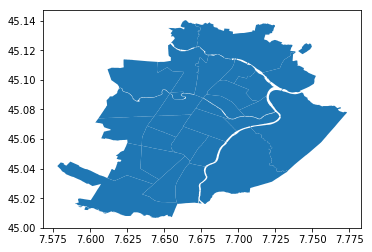

In [100]:
#Read GeoJson
fname = "./ultimi_geojson_CSI/ex_quartieri.geojson"
df = gpd.read_file(fname)
df.plot()

In [8]:
#Read CSV
df = pd.read_csv("scuole.csv", sep=";", encoding="ISO-8859-1", decimal=",")
df.rename(columns={"COORD_X": 'latitude', "COORD_Y": 'longitude'}, inplace=True)